In [1]:
import tensorflow as tf
import torch
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import sys
from pycocotools2.coco import COCO as COCO2
import json

2024-05-21 23:39:54.077118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda" if use_cuda else "cpu")

dataDir='.'
dataType='val2014'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
coco = COCO2(annFile)

CUDA is available!  Training on GPU ...
loading annotations into memory...
0:00:00.245405
creating index...
index created!


In [3]:
captioned_ids = []
sequence = "<|endoftext|>"
numbers = []
with open("./results/captions_1.txt", 'r') as file:
    for line in file:
        if line.strip().isdigit():
            captioned_ids.append(int(line.strip()))

In [4]:
evals = []
formatted_list = []
for j in range(1,7):
    with open(f"./results/captions_{j}.txt", 'r') as file:
        caps = file.read()

    caps_not_formatted = []
    texts = caps.split('<|assistant|>')
    for t in texts:
        caps_not_formatted.append(t.split('<|endoftext|>')[0])
    caps_not_formatted = caps_not_formatted[1:]
    caps_formatted = []
    caps_formatted = caps_not_formatted
    formatted_list.append(caps_formatted)


In [5]:
annIds = coco.getAnnIds(imgIds=captioned_ids)
anns = coco.loadAnns(annIds)
ref_captions = {}
for i in range(len(captioned_ids)):
    img_id = captioned_ids[i]
    img_id_refs = []
    for j in range(5):
        img_id_refs.append(anns[i*5+j]['caption'])
    ref_captions[img_id] = img_id_refs

# Embedding generation

In [6]:
model = SentenceTransformer('thenlper/gte-small')

In [7]:
data = {}

for i in range(len(captioned_ids)):
    img_id = captioned_ids[i]
    data[img_id] = {}
    
    ref_embeddings = []
    for ref in ref_captions[img_id]:
        embedding = model.encode(ref)
        ref_embeddings.append(embedding)
    data[img_id]['ref'] = ref_embeddings
    
    for j in range(6):
        embedding = model.encode(formatted_list[j][i])
        data[img_id][f'pred{j+1}'] = embedding


# Comparison

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.DataFrame()
#for j in range(6):
similarities = []
for img in data:
    d = dict()
    d['id'] = img
    c1 = cosine_similarity(data[img][f'pred1'].reshape(1,-1), data[img]['ref'][0].reshape(1,-1))[0][0]
    for i in range(4):
        c2 = cosine_similarity(data[img][f'pred1'].reshape(1,-1), data[img]['ref'][1+i].reshape(1,-1))[0][0]
        c1 = max(c1,c2)
    d[f'cosine_distance_1'] = c1
    similarities.append(d)
    
df = pd.DataFrame(similarities)

for j in range(1,6):
    similarities = []
    for img in data:
        c1 = cosine_similarity(data[img][f'pred{j+1}'].reshape(1,-1), data[img]['ref'][0].reshape(1,-1))[0][0]
        for i in range(4):
            c2 = cosine_similarity(data[img][f'pred{j+1}'].reshape(1,-1), data[img]['ref'][1+i].reshape(1,-1))[0][0]
            c1 = max(c1,c2)
        similarities.append(c1)
    df[f'cosine_distance_{j+1}'] = similarities

In [10]:
df

,id,cosine_distance_1,cosine_distance_2,cosine_distance_3,cosine_distance_4,cosine_distance_5,cosine_distance_6
0,183181,0.894626,0.892051,0.847631,0.900808,0.864423,0.881792
1,167952,0.843359,0.843650,0.852052,0.843352,0.839074,0.870049
2,245006,0.863632,0.898974,0.883381,0.887923,0.884905,0.888312
3,16817,0.847253,0.843717,0.880070,0.859990,0.846509,0.843387
4,541887,0.896360,0.872730,0.872949,0.824140,0.873492,0.891073
5,541086,0.879304,0.864562,0.877151,0.859202,0.870305,0.883729
6,244462,0.878847,0.872821,0.829047,0.814882,0.841038,0.841932
7,536517,0.896340,0.880859,0.902002,0.851368,0.851518,0.853839
8,63047,0.827514,0.821325,0.817234,0.820953,0.816548,0.818866
9,256055,0.785983,0.806505,0.780331,0.777227,0.780951,0.808198


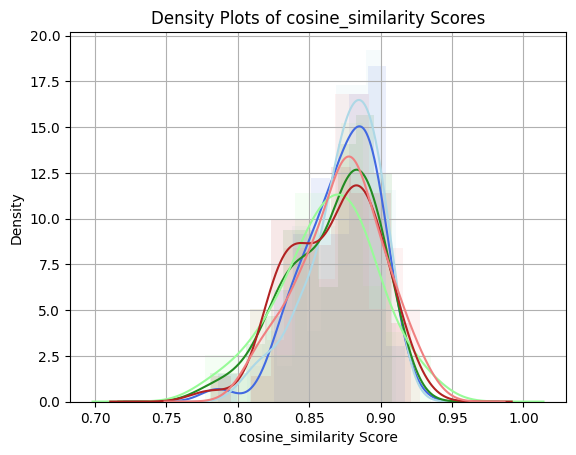

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

colors = ['royalblue', 'lightblue', 'forestgreen', 'palegreen', 'firebrick', 'lightcoral']
metric = 'cosine_similarity'
densities = []
for i in range(6):
    scores = df[f'cosine_distance_{i+1}'] 
    #kde = stats.gaussian_kde(scores)
    #x = np.linspace(min(scores), max(scores), 400)
    #density = kde(x)
    densities.append(scores)

# Create the plot with multiple lines
plt.xlabel(f'{metric} Score')
plt.ylabel('Probability Density')
plt.title(f'Density Plots of {metric} Scores')

# Loop through densities and plot them with labels
for i, density in enumerate(densities):
    label = f"Configuration {i+1}"  # Create labels for each density
    pd.Series(density).plot(kind= "kde", color = colors[i])
    plt.hist(density, bins=10, alpha = 0.1, label=label, color = colors[i], density = True)

plt.grid(True)
#plt.legend(title="Evaluations", loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})  # Adjust font size to 8
plt.savefig(f'{metric}_densities.jpg')
plt.show()
plt.clf()

In [24]:
for col in df.columns:
    print(np.mean(df[col]))

258405.34
0.872131
0.87445533
0.8653639
0.86301386
0.86667174
0.8722512
